In [228]:
import tensorflow as tf
import numpy as np
import pandas as pd

import tensorflow_hub as hub

import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots

from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import concatenate

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model

import tensorflow_datasets as tfds

In [198]:
train_limpio = pd.read_csv("train_limpio_con_stemming.csv",encoding = "ISO-8859-1")
train_limpio.columns

Index(['text', 'target', 'cantidad_links', 'cantidad_signos_pregunta',
       'repeticiones', 'longitud_tweet', 'letras_seguidas', 'sentimiento',
       'objetividad', 'the',
       ...
       'he is', 'insultos_por_tweet', 'expresiones_por_tweet', 'bombing',
       'suicide', 'accident', 'disaster', 'police', 'died', 'years'],
      dtype='object', length=818)

In [199]:
target = train_limpio["target"]
target.head(2)

0    1
1    1
Name: target, dtype: int64

In [200]:
VALIDATION_SIZE = .8
TEST_SIZE = .9
WANTED_COLUMNS = ["text", "cantidad_links", "cantidad_signos_pregunta", "repeticiones", "longitud_tweet", "letras_seguidas", "sentimiento", "insultos_por_tweet", "expresiones_por_tweet", "target"]
df = train_limpio[WANTED_COLUMNS]
raw_train_df, raw_val_df, raw_test_df = np.split(df.sample(frac=1), [int(VALIDATION_SIZE*len(df)), int(TEST_SIZE*len(df))])

## Sily inputs for text

In [202]:
raw_train_ds = tf.data.Dataset.from_tensor_slices((raw_train_df["text"].to_numpy(dtype="str"), raw_train_df["target"].values))
raw_val_ds = tf.data.Dataset.from_tensor_slices((raw_val_df["text"].to_numpy(dtype="str"), raw_val_df["target"].values))
raw_test_ds = tf.data.Dataset.from_tensor_slices((raw_test_df["text"].to_numpy(dtype="str"), raw_test_df["target"].values))


train_examples_batch, train_labels_batch = next(iter(raw_train_ds.batch(10)))

In [203]:
raw_train_ds

<TensorSliceDataset shapes: ((), ()), types: (tf.string, tf.int64)>

In [204]:
train_examples_batch

<tf.Tensor: shape=(10,), dtype=string, numpy=
array([b'let  me  be  your  hot  blaze  fantasi  \nescort gfe dubai ',
       b'mprnew  wow that a lot of traumatis kid',
       b'cspanwj if  collud  take wht f usagov auth  make her look blk wbioterrorismampus her lglorg idi id still her',
       b'sexydragonmag ive come to the realize that i just dont have the attent span for mass battl game both paint and play',
       b'young children among those rescu from capsiz boat off libya  via irishtimesworld',
       b' \xc3\x82\xc2\x89\xc3\x82\xc2\x9b\xc3\x82\xc2\x92 the bug that almost crash the euro  ',
       b'im more into the healingreviv side of the game rather than better attack so for now siren gt all other charact except new girl',
       b'my vibrat shape vape done bust',
       b' of those day when ya dont realiz till alreadi in transit that a train derail at the metro st closest to work ',
       b'emerg shutdown system  edmonton '], dtype=object)>

In [205]:
train_labels_batch

<tf.Tensor: shape=(10,), dtype=int64, numpy=array([0, 0, 1, 0, 1, 1, 0, 0, 1, 1])>

In [206]:
hub_layer(train_examples_batch[:3])

<tf.Tensor: shape=(3, 20), dtype=float32, numpy=
array([[ 7.78817177e-01, -3.45532417e-01,  7.26981461e-02,
         1.42955983e+00, -1.44070482e+00, -1.17642117e+00,
        -1.08898020e+00,  1.40121686e+00,  3.06079894e-01,
         2.28816897e-01, -1.83987021e+00,  8.15565109e-01,
         1.19656168e-01,  6.98064566e-02, -1.36603749e+00,
         1.64199084e-01,  1.19086182e+00, -3.78182739e-01,
        -1.17478216e+00, -4.25115854e-01],
       [ 1.04344773e+00, -7.06931353e-01,  5.31961262e-01,
        -3.13294649e-01, -1.17202866e+00, -8.57403457e-01,
        -6.78202927e-01,  3.52341115e-01,  1.28815961e+00,
        -5.51523805e-01, -9.45174098e-01,  5.82427204e-01,
         3.67816061e-01,  1.41962077e-02, -1.44475639e+00,
         4.24072705e-02,  1.05716646e+00, -1.27035414e-03,
        -1.20484459e+00, -1.22698896e-01],
       [ 7.33358026e-01, -1.21367967e+00,  7.97611237e-01,
         6.12451732e-01, -8.09347928e-01, -5.70859373e-01,
        -9.68348205e-01,  1.29723930e+0

## Super inputs

In [207]:
embedding = "https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim/1"
hub_layer = hub.KerasLayer(embedding, input_shape=[], 
                           dtype=tf.string, trainable=True)

In [208]:
wantedFeaturesColumns = [x for x in WANTED_COLUMNS if x not in ["text", "target"]]

raw_ds_text = tf.data.Dataset.from_tensor_slices((hub_layer(df["text"].to_numpy(dtype="str")), df["target"].values))
raw_ds_features = tf.data.Dataset.from_tensor_slices(tf.cast(df[wantedFeaturesColumns], tf.float32))

raw_ds_text = raw_ds_text.shuffle(buffer_size=5000)
raw_train_ds_text = raw_ds_text.skip(400)
raw_validate_ds_text = raw_ds_text.take(400)

raw_ds_features = raw_ds_features.shuffle(buffer_size=5000)
raw_train_ds_features = raw_ds_features.skip(400)
raw_validate_ds_features = raw_ds_features.take(400)

In [209]:
trainTextX = raw_train_ds_text.map(lambda x,y : x)
trainY = raw_train_ds_text.map(lambda x,y : y)

validateTextX = raw_validate_ds_text.map(lambda x,y : x)
validateY = raw_validate_ds_text.map(lambda x,y : y)

trainFeaturesX = raw_train_ds_features
validateFeaturesX = raw_validate_ds_features

In [210]:
list(trainTextX)[0]

<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([ 0.6972883 , -0.79174185,  0.5646454 ,  0.6194398 , -0.32770282,
       -1.1752329 , -0.43616128,  0.9017426 ,  1.393946  ,  0.35132346,
       -0.2433304 ,  0.21170956, -0.20233686,  0.03096061, -1.0258665 ,
        0.6851256 , -0.21584888, -0.5947345 , -0.95492905, -0.3201894 ],
      dtype=float32)>

In [211]:
list(trainY)[0]

<tf.Tensor: shape=(), dtype=int64, numpy=0>

In [212]:
list(trainFeaturesX)[0]

<tf.Tensor: shape=(8,), dtype=float32, numpy=
array([  0.        ,   0.        ,   1.        , 120.        ,
         2.        ,   0.33333334,   0.        ,   0.        ],
      dtype=float32)>

In [213]:
list(validateTextX)[0]

<tf.Tensor: shape=(20,), dtype=float32, numpy=
array([ 0.33892387, -0.0784743 ,  0.9319265 ,  0.6504192 , -0.51951253,
       -0.9500785 , -0.53897935, -0.1124311 , -0.02577024, -0.5859678 ,
       -0.07040573,  0.04609833,  0.4933024 ,  0.3541402 , -0.60115904,
        0.11465197,  0.97945863, -0.07682869, -0.64944315, -0.7121132 ],
      dtype=float32)>

In [214]:
list(validateY)[0]

<tf.Tensor: shape=(), dtype=int64, numpy=1>

In [215]:
list(validateFeaturesX)[0]

<tf.Tensor: shape=(8,), dtype=float32, numpy=array([ 1.,  0.,  1., 50.,  2.,  0.,  0.,  0.], dtype=float32)>

In [259]:
np.array(validateFeaturesX, dtype=np.float32)

TypeError: float() argument must be a string or a number, not 'TakeDataset'

### Esto es el modelo facil y, aunque parezca lo más dificil, es lo que más se entiende hasta ahora

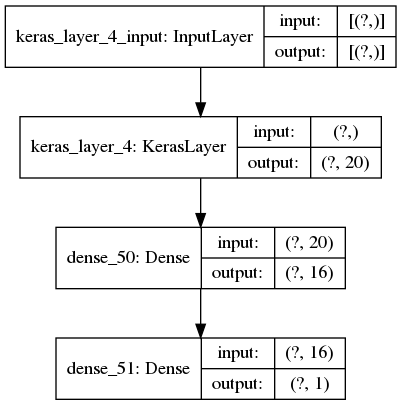

In [216]:
model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(1))
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy', 'binary_crossentropy'])
history = model.fit(raw_train_ds.shuffle(5000).batch(512),
                    epochs=30,
                    validation_data=raw_val_ds.batch(512), verbose=0)
historyMap = {}
historyMap["some model"] = history
keras.utils.plot_model(model, "my_first_model.png", show_shapes=True)

In [217]:
model.evaluate(raw_test_ds.batch(512))

2/2 [==============================] - 0s 3ms/step - loss: 0.5183 - accuracy: 0.7605 - binary_crossentropy: 2.6814


[0.5182659029960632, 0.7605041861534119, 2.6813831329345703]

# Modelo flash

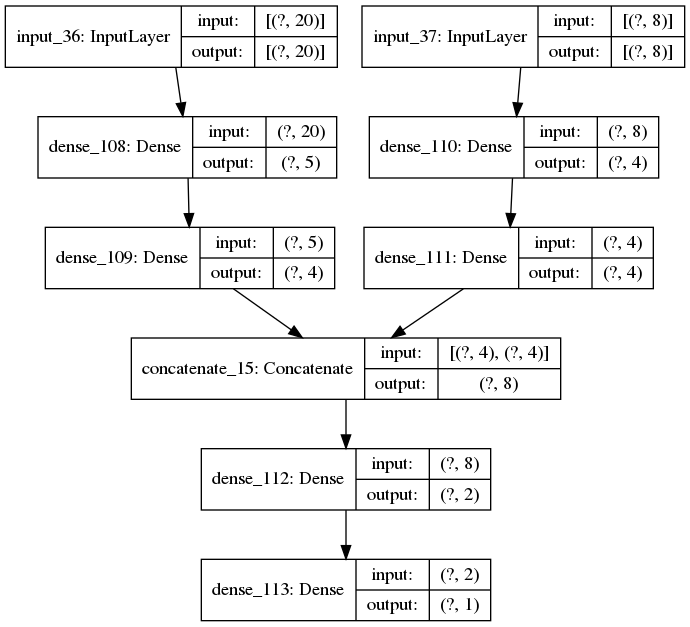

In [245]:
# define two sets of inputs
inputText = keras.Input(shape=(20,), dtype="float32")
inputFeatures = keras.Input(shape=(8,))
# the first branch operates on the first input
x = Dense(5, activation="relu")(inputText)
x = Dense(4, activation="relu")(x)
x = Model(inputs=inputText, outputs=x)
# the second branch opreates on the second input
y = Dense(4, activation="relu")(inputFeatures)
y = Dense(4, activation="relu")(y)
y = Model(inputs=inputFeatures, outputs=y)
# combine the output of the two branches
combined = concatenate([x.output, y.output])
# apply a FC layer and then a regression prediction on the
# combined outputs
z = Dense(2, activation="relu")(combined)
z = Dense(1, activation="linear")(z)
# our model will accept the inputs of the two branches and
# then output a single value
model = Model(inputs=[inputText, inputFeatures], outputs=z)

opt = Adam(lr=1e-3, decay=1e-3 / 200)
model.compile(loss="mean_absolute_percentage_error", optimizer=opt)

keras.utils.plot_model(model, "my_second_model.png", show_shapes=True)

In [257]:
model.fit(
	x=[np.asarray(trainTextX), np.asarray(trainFeaturesX)], y=np.asarray(trainY),
	validation_data=([validateTextX, validateFeaturesX], validateY),
	epochs=200)

ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type MapDataset).

## Submission

In [ ]:
test_limpio = pd.read_csv("test_limpio_con_stemming.csv",encoding = "ISO-8859-1")
test_limpio.head(2)

In [ ]:
predictionsInputsDF = test_limpio["text"]

In [ ]:
predictionsInputsX = tf.data.Dataset.from_tensor_slices((predictionsInputsDF.to_numpy(dtype="str")))

In [ ]:
predictionsOutput = model.predict_classes(predictionsInputsX.batch(512))

In [ ]:
test_limpio["target"] = predictionsOutput
test_limpio[["id", "target"]].head(10)

In [ ]:
test_limpio[["id", "target"]].to_csv('NN_predictions.csv', index=False)